In [5]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [2]:
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

# load IBMQ account
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

/tmp/ipykernel_678650/1383917195.py:7: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
import matplotlib as mpl
from qiskit import Aer


In [4]:
sim_backend = Aer.get_backend('statevector_simulator')

In [ ]:
# store amplitudes for combined plot
init_amplitudes_save = []
outputstates_save = []
results_save = []


In [6]:
def plot_state_vector(state, fig=None, ax=None, include_labels_colorbar_etc=True):
    if fig==None:
        fig=plt.figure()
        ax=plt.gca()
    
    absolut, angle = np.abs(state), np.angle(state)
    x = np.arange(len(absolut))
    norm = plt.Normalize(-np.pi, np.pi)

    if len(absolut) < 1000: # barplots sind langsamer. Aber das ist dann okay.
        plot = ax.bar(np.arange(len(absolut)), absolut, color=cm.gist_rainbow(norm(angle)))
    else:
        ax.scatter(x, absolut, 2, color=cm.gist_rainbow(norm(angle)))
    
    if include_labels_colorbar_etc:
        sm = cm.ScalarMappable(cmap=cm.gist_rainbow, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, cmap=cm.gist_rainbow, ax=ax)
        ax.set_xlabel("basis state")
        ax.set_ylabel("absolute value of amplitude, color gives phase")

    

In [7]:
# init
nqubits=4
circ = QuantumCircuit(nqubits, nqubits)

# write starting amplitude

#init_amplitudes = np.exp(3*-1j* 2*np.pi*np.linspace(0,1-2**-nqubits,2**nqubits))

init_amplitudes = np.zeros(2**nqubits)
init_amplitudes[1] = 1
init_amplitudes[-1] = -.5

init_amplitudes /= np.sqrt(np.sum(np.abs(init_amplitudes)**2))
circ.initialize(init_amplitudes)

drawing


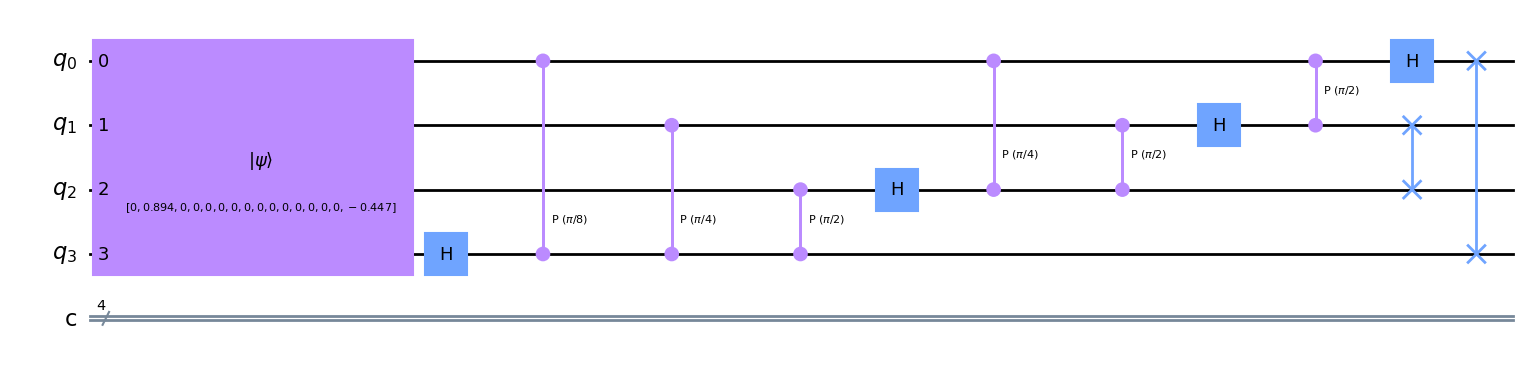

In [8]:
# Quantum Fourier Trafo
# In Qiskit, the least important bit in binary numbers is the 0th qubit.
# The transformation of each qubit depends only on the initial state of the
# lower indexed qubits. Therefore, start with the highest indexed qubit.
for i in range(nqubits-1,-1,-1):
	# apply Hadamard Gate on qubit i
    circ.h(i)
    for j in range(0, i):
        # apply controled phase shift on qubit i controled by j
        circ.cp(2*np.pi/2**(i-j+1), j, i)
for i in range(nqubits//2):
	circ.swap(i, nqubits-i-1)
    
image = None
if nqubits < 8:
    print("drawing")
    image = circ.draw()
else:
    print("not drawing circit because it is too big")
image

In [9]:
job = sim_backend.run(circ)
result = job.result()
outputstate = result.get_statevector(circ, decimals=10)
print(outputstate)
#probs=np.abs(outputstate)**2
#print(np.round(probs,3))

Statevector([ 0.1118034 +0.j        ,  0.10329287+0.12835593j,
              0.07905694+0.23717082j,  0.04278531+0.30987862j,
              0.        +0.3354102j , -0.04278531+0.30987862j,
             -0.07905694+0.23717082j, -0.10329287+0.12835593j,
             -0.1118034 -0.j        , -0.10329287-0.12835593j,
             -0.07905694-0.23717082j, -0.04278531-0.30987862j,
             -0.        -0.3354102j ,  0.04278531-0.30987862j,
              0.07905694-0.23717082j,  0.10329287-0.12835593j],
            dims=(2, 2, 2, 2))


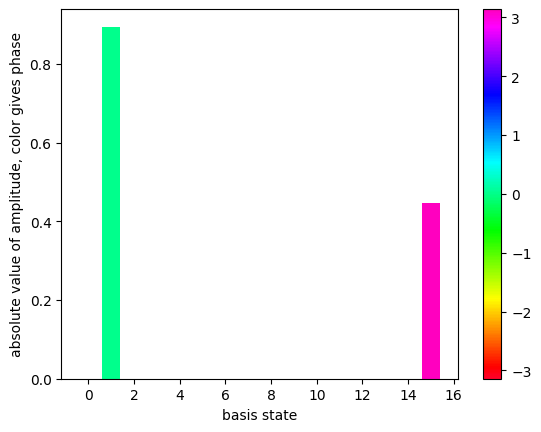

In [10]:
plot_state_vector(init_amplitudes)

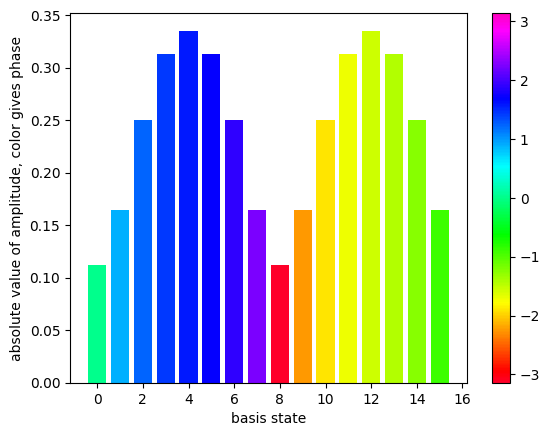

In [11]:
plot_state_vector(outputstate)

In [12]:
init_amplitudes_save.append(init_amplitudes)
outputstates_save.append(outputstate)

# Run on Qunatum Computer

In [64]:
# get the least busy backend device with less than or equal to nqubits

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_belem


In [73]:
backend = provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True)[0]

In [75]:
# add mesurements to circuit
circ.measure(range(nqubits), range(nqubits))

In [76]:
shots = 2048
transpiled_qc = transpile(circ, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job)

Job Status: job is queued (None)

KeyboardInterrupt: 

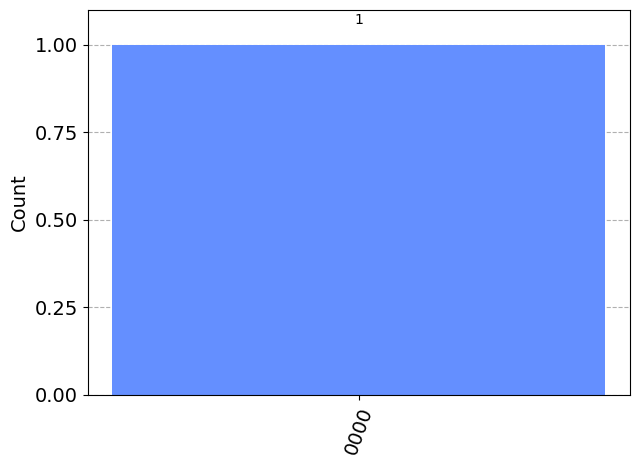

In [161]:
counts = job.result().get_counts()
plot_histogram(counts)

In [13]:
job = provider.runtime.job("cik0nlmuepl060pda4kg")

In [30]:
res = job.result()

In [36]:
np.array(list(res['results'][0]['data']['counts'].values()))

array([4154, 4038])

In [6]:
# retrieve old jobs
# (load accont first with import)

IDs = ["ci66ade8t9vighs562dg", "chs9ql8recnk2p3dc2ug", "chsbcphoq2qn3r0s3eug", "chsbocqi3durlgppiae0"]
results_save = []

for ID in IDs:
    results_save.append(provider.runtime.job(ID))
    #results_save.append(provider.backend.retrieve_job(ID))

QiskitBackendNotFoundError: 'No backend matches the criteria'

In [57]:
import jsonpickle
data = jsonpickle.encode({"initialized state vector" : [list(arr) for arr in init_amplitudes_save],
                           "simulated state after QFT" : [list(arr) for arr in outputstates_save],
                           "Quantum computer results": [job.result() for job in results_save]})

with open("QFT_reults.json", "w") as f:
    f.write(data)

In [14]:
import jsonpickle
with open("QFT_reults.json", "r") as f:
    data = jsonpickle.decode(f.read())
init_amplitudes_save = data["initialized state vector"]
outputstates_save = data["simulated state after QFT"]


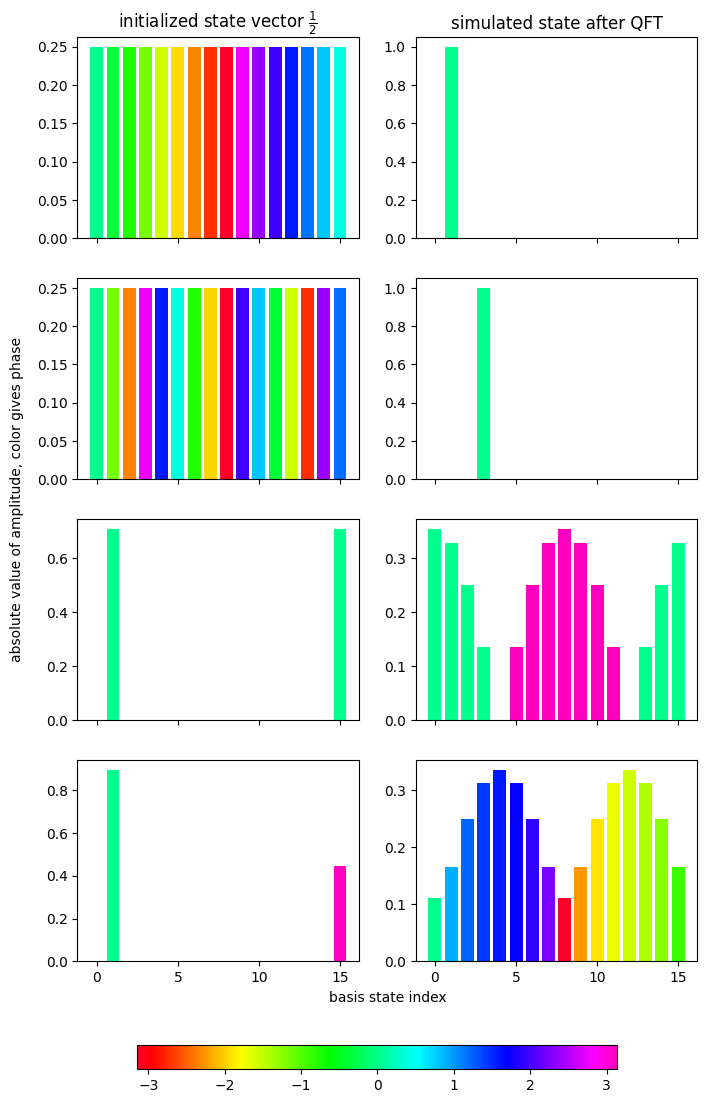

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize = (8,12))
plt.setp(axes[0,0], title='initialized state vector')
plt.setp(axes[0,1], title='simulated state after QFT')
#fig.suptitle('An overall title', size=20)
for i, axes_row in enumerate(axes):
    plot_state_vector(init_amplitudes_save[i], fig, axes_row[0], include_labels_colorbar_etc=False)
    plot_state_vector(outputstates_save[i], fig, axes_row[1], include_labels_colorbar_etc=False)


# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("basis state index")
plt.ylabel("absolute value of amplitude, color gives phase\n", rotation='vertical')

# add a colorbar below the xlabels
norm = plt.Normalize(-np.pi, np.pi)
sm = cm.ScalarMappable(cmap=cm.gist_rainbow, norm=norm)
sm.set_array([])

cax = fig.add_axes([0.2, 0.02, 0.6, 0.02]) # [left, bottom, width, height]
fig.colorbar(sm, cmap=cm.gist_rainbow, cax=cax, orientation='horizontal')

#fig.tight_layout()
#fig.subplots_adjust(top=0.9) 

plt.show()

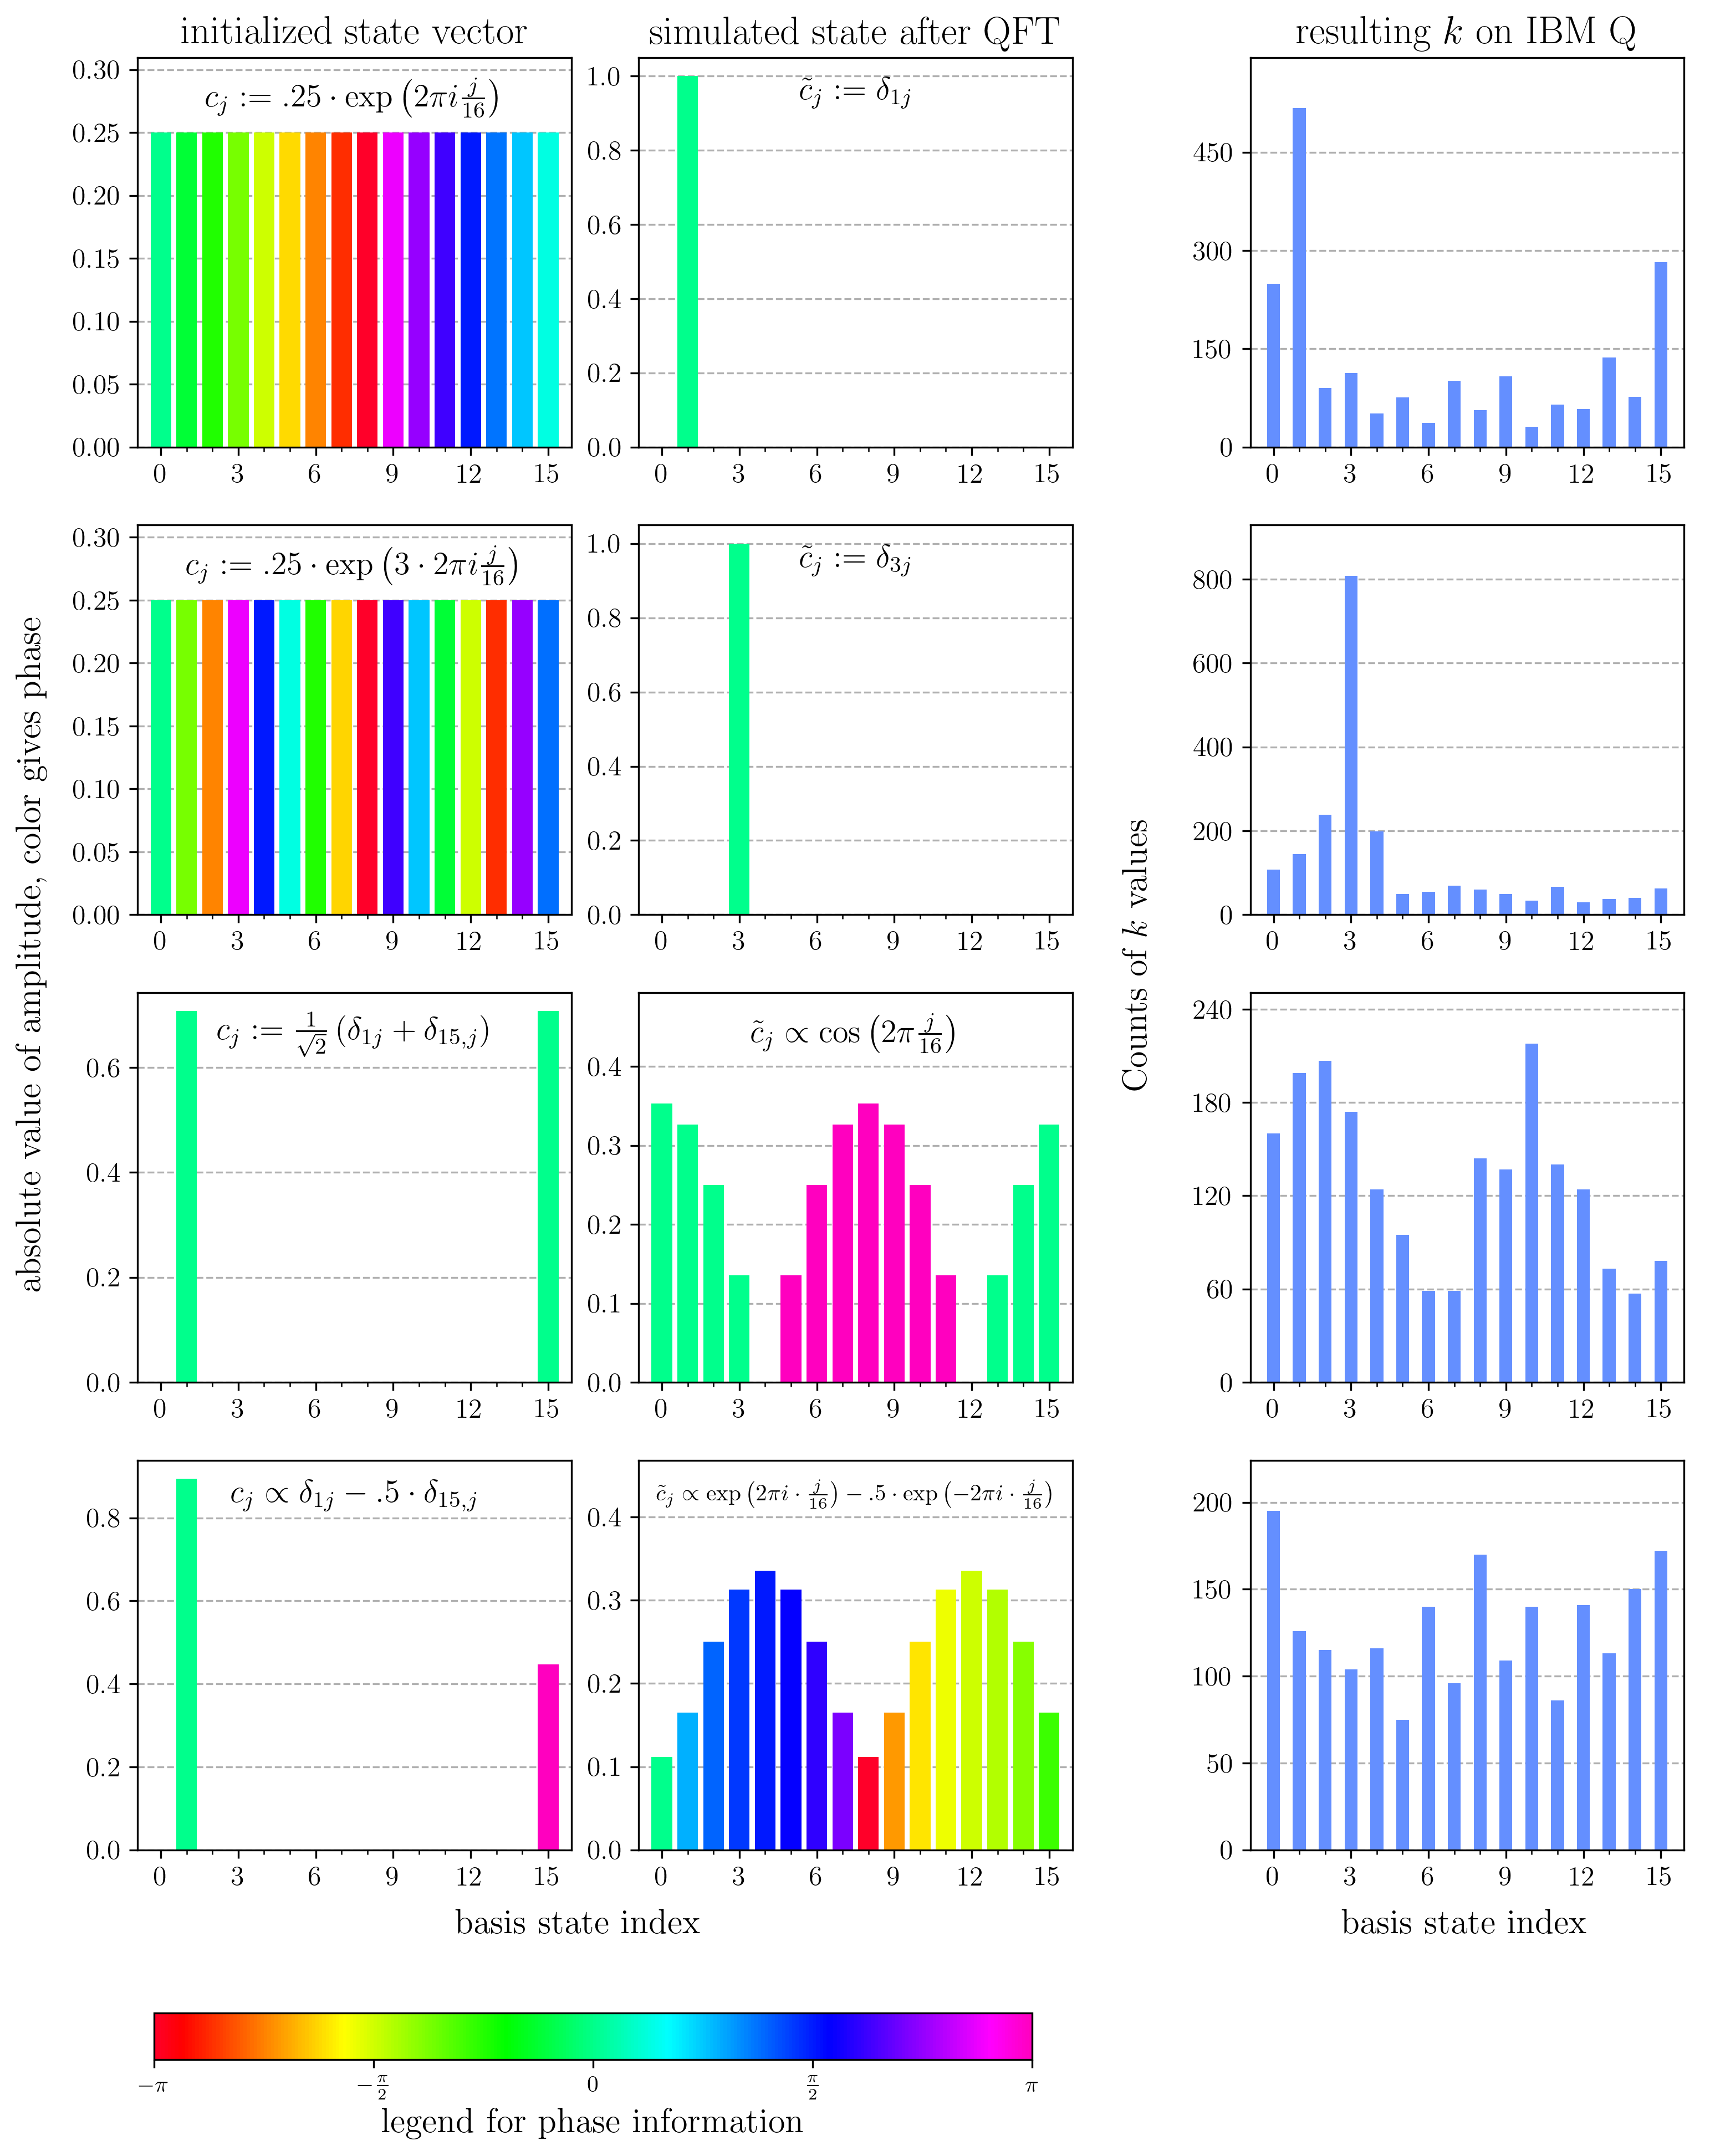

In [22]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Sans Serif"#"DejaVu Sans"
})

legend = [[r"c_{j}:=.25\cdot\exp\left(2\pi i\frac{j}{16}\right)", r"\tilde{c}_{j}:=\delta_{1j}"],
          [r"c_{j}:=.25\cdot\exp\left(3\cdot2\pi i\frac{j}{16}\right)", r"\tilde{c}_{j}:=\delta_{3j}"],
          [r"c_{j}:=\frac{1}{\sqrt{2}}\left(\delta_{1j}+\delta_{15,j}\right)", r"\tilde{c}_{j}\propto\cos\left(2\pi\frac{j}{16}\right)"],
          [r"c_{j}\propto\delta_{1j}-.5\cdot\delta_{15,j}", r"\tilde{c}_{j}\propto\exp\left(2\pi i\cdot\frac{j}{16}\right)-.5\cdot\exp\left(-2\pi i\cdot\frac{j}{16}\right)"]]

fig, axes = plt.subplots(ncols=4, nrows=4, sharex=False, figsize = (12,14), gridspec_kw={'width_ratios': [1, 1, .1, 1]})
fig.set_dpi(300)
#plt.setp(axes[0,0], title='initialized state vector', fontsize=20)
axes[0,0].set_title('initialized state vector', fontsize=17)
axes[0,1].set_title('simulated state after QFT', fontsize=17)
axes[0,3].set_title('resulting $k$ on IBM Q', fontsize=17)
#fig.suptitle('An overall title', size=20)
for i, axes_row in enumerate(axes):

    # first two columns
    plot_state_vector(init_amplitudes_save[i], fig, axes_row[0], include_labels_colorbar_etc=False)
    plot_state_vector(outputstates_save[i], fig, axes_row[1], include_labels_colorbar_etc=False)
    
    # print text
    for j in range(2):
        axes_row[j].text(0.5, 0.95, f"${legend[i][j]}$", horizontalalignment='center', verticalalignment='top', transform=axes_row[j].transAxes, fontsize=(14 if (i,j) != (3,1) else 10))
        
        # rescale y-axis if needed
        _, top = axes_row[j].set_ylim(auto=True)
        if 2*i + j in [0,2]:
            axes_row[j].set_ylim(0, top*1.18)
        if 2*i + j in [5,7]:
            axes_row[j].set_ylim(0, top*1.33)
    
    # last column
    res = results_save[i].result()["results"][0]["data"]["counts"]
    res = {int(key, 16) : val for key, val in res.items()}
    plot_histogram(res, ax=axes_row[3], bar_labels=False)
    axes_row[3].set_ylim(0, max(res.values())*1.15)
    axes_row[3].set_ylabel("")

    # set style
    for i, ax in enumerate(axes_row):
        if i == 2:
            # this place is just used to get the space for the new y-label. We don't want to see plots here.
            ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
            ax.set_frame_on(False)
            continue
        ax.tick_params(labelsize=12,)
        ax.yaxis.grid(linestyle="--")
        ax.set_axisbelow(True)
        ax.tick_params(axis="x", rotation=0)
        ax.xaxis.set_major_locator(MultipleLocator(3))
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.xaxis.set_minor_formatter('')
        ax.set_xlim(-0.9, 15.9)
    
    

# add a big axis, hide frame
#fig.add_subplot(111, frameon=False)
axes = fig.subplots(ncols=3, gridspec_kw={'width_ratios': [2, .1, 1]})
# hide tick and tick label of the big axis
for ax in axes:
    ax.set_frame_on(False)
    ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axes[0].set_xlabel("basis state index", size=15, labelpad=10)
axes[0].set_ylabel("absolute value of amplitude, color gives phase\n", rotation='vertical', size=15)




# add a big axis, hide frame
#fig.add_subplot(133, frameon=False)
# hide tick and tick label of the big axis
#plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axes[2].set_ylabel("Counts of $k$ values\n", rotation='vertical', size=15)
axes[2].set_xlabel("basis state index", size=15, labelpad=10)





# add a colorbar below the xlabels
norm = plt.Normalize(-np.pi, np.pi)
sm = cm.ScalarMappable(cmap=cm.gist_rainbow, norm=norm)
sm.set_array([])

cax = fig.add_axes([0.4/3, 0.02, 0.44, 0.02]) # [left, bottom, width, height]
cbar = fig.colorbar(sm, cmap=cm.gist_rainbow, cax=cax, orientation='horizontal', ticks=np.arange(-1,1.5,.5)*np.pi)
cbar.ax.set_xticklabels(['$-\\pi$', '$-\\frac{\\pi}{2}$', '$0$', '$\\frac{\\pi}{2}$', '$\\pi$'])
cbar.ax.set_xlabel("legend for phase information", size=15, labelpad=4)
#plt.setp(cbar.ax, "title")

#fig.tight_layout()
#fig.subplots_adjust(top=0.9) 
#plt.tick_params(labelsize="small")
plt.show()

In [58]:
for job in results_save:
    fig = plt.figure()
    plot_histogram(results_save[0].result()["results"][0]["data"]["counts"])
    plt.show()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

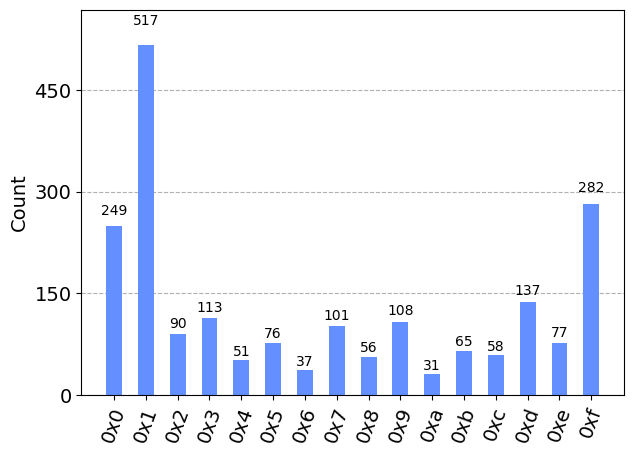

In [162]:
plot_histogram(results_save[0].result()["results"][0]["data"]["counts"])